In [1]:
import os
import pdb
import h5py
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Config

In [2]:
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
enformer_data_dir = "/global/scratch/users/aniketh/enformer_data/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
code_dir = "/global/home/users/aniketh/finetuning-enformer/"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"
gene_class_path = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

models_dir = os.path.join(root_save_dir, "saved_models")
test_preds_dir = os.path.join(root_save_dir, "test_preds_final")
rest_unseen_preds_dir = os.path.join(root_save_dir, "rest_unseen_preds_final")
ISM_preds_dir = os.path.join(root_save_dir, "ISM")

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")
rest_unseen_h5_path = os.path.join(data_dir, "rest_unseen.h5")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
FUSION_PREDS_DIR = "../fusion/preds"
FUSION_SCALING_PREDS_DIR = "../fusion/preds_scaling/"

all_main_run_names = {
    "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    #     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression_with_Malinois_MPRA": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_MPRA_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {malinois_data_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "baseline": "",
}
all_seeds = [42, 97, 7]
subsample_fracs = [0.2, 0.4, 0.6, 0.8]
all_afs = (
    list(np.arange(0.01, 0.1, 0.01).round(2))
    + list(np.arange(0.1, 0.4, 0.05).round(2))
    + list(np.arange(0.41, 0.49, 0.01).round(2))
)

In [3]:
ALL_PREDS_PATHS = {}
ALL_REST_UNSEEN_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    if run == "baseline":
        ALL_PREDS_PATHS[run] = os.path.join(test_preds_dir, run)
        ALL_REST_UNSEEN_PREDS_PATHS[run] = os.path.join(rest_unseen_preds_dir, run)
    else:
        for i, seed in enumerate(all_seeds):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)
            ALL_REST_UNSEEN_PREDS_PATHS[model_name] = os.path.join(
                rest_unseen_preds_dir, model_name
            )

# TEST RUNS FOR SUBSAMPLED TRAIN SET RUNS FOR REGRESSION
for run in ["regression"]:
    for i, seed in enumerate(all_seeds):
        for j, frac in enumerate(subsample_fracs):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}_subsample_ratio_{frac}"
            ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)

# TEST RUNS USING SUBSAMPLED VARIANTS FOR REGRESSION
for run in ["regression"]:
    for i, seed in enumerate(all_seeds):
        for j, af in enumerate(all_afs):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            if not os.path.exists(
                os.path.join(test_preds_dir, model_name, f"af_{af}", "test_preds.npz")
            ):
                print(
                    "Dir missing", os.path.join(test_preds_dir, model_name, f"af_{af}")
                )
                continue
            ALL_PREDS_PATHS[model_name + f"_af_{af}"] = os.path.join(
                test_preds_dir, model_name, f"af_{af}"
            )

test_h5 = h5py.File(test_h5_path, "r")
rest_unseen_h5 = h5py.File(rest_unseen_h5_path, "r")

# Read test set predictions and compute correlations

In [4]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df


def load_other_model_preds_df(preds_df_path):
    preds_df = pd.read_csv(preds_df_path, index_col=0).T
    return preds_df


def load_finetuned_preds(PREDS_PATH, h5_obj):
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    ancestries_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    ancestries = h5_obj["ancestries"]
    for (pred, gene, sample, ancestry) in zip(preds, genes, samples, ancestries):
        preds_by_gene[gene][sample] = pred
        ancestries_by_gene[gene][sample] = ancestry.decode("utf-8")
    return preds_by_gene, ancestries_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df):
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values.astype("float32")
        assert np.isnan(gene_preds).sum() == 0
        assert np.isnan(gene_counts).sum() == 0
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]

        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(
                f"Gene {g} has invalid predictions/counts and thus has a nan pearsonR"
            )
            corrs[g] = 0

    return corrs


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds):
    corrs = {}
    for g in finetuned_preds:
        if g not in preds_df.columns:
            print(f"Gene {g} has no predictions/counts and thus has a nan PearsonR")
            corrs[g] = 0
            continue

        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]

        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(
                f"Gene {g} has invalid predictions/counts and thus has a nan PearsonR"
            )
            corrs[g] = 0

    return corrs


def summarize_perf(corrs):
    genes = list(corrs.keys())
    corrs_l = [corrs[g] for g in genes]

    df = pd.DataFrame(
        {
            "gene": genes,
            "Pearson": corrs_l,
            "|Pearson|": np.abs(corrs_l),
        }
    )

    return df

In [5]:
gene_class = pd.read_csv(gene_class_path)
geuvadis_df = load_geuvadis_data()
geuvadis_df["gene"] = geuvadis_df.index
gene_class = gene_class.merge(
    geuvadis_df[["gene", "Chr"]], on="gene", how="right"
).reset_index(drop=True)
gene_class.loc[pd.isna(gene_class["class"]), "class"] = "unseen"

fusion_dfs = {}
for model_csv in os.listdir(FUSION_PREDS_DIR):
    if model_csv.endswith(".csv"):
        fusion_dfs[model_csv.split(".")[0]] = load_other_model_preds_df(
            os.path.join(FUSION_PREDS_DIR, model_csv)
        )

In [6]:
if (
    (not os.path.exists("all_gene_perf.csv"))
    or (not os.path.exists("perf_summary.csv"))
    or (not os.path.exists("fusion_scaling.csv"))
):
    gene_perf = None

    finetuned_preds_for_baseline_comparison = None

    for model in ALL_PREDS_PATHS:
        print(model)

        PREDS_PATH = ALL_PREDS_PATHS[model]
        finetuned_preds, ancestries_by_gene = load_finetuned_preds(PREDS_PATH, test_h5)
        finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)

        if not (("_subsample_ratio_" in model) or ("_af_" in model)):
            REST_UNSEEN_PREDS_PATH = ALL_REST_UNSEEN_PREDS_PATHS[model]
            (
                rest_unseen_finetuned_preds,
                rest_unseen_ancestries_by_gene,
            ) = load_finetuned_preds(REST_UNSEEN_PREDS_PATH, rest_unseen_h5)
            rest_unseen_finetuned_corrs = get_finetuned_corrs(
                rest_unseen_finetuned_preds, geuvadis_df
            )

            finetuned_corrs.update(rest_unseen_finetuned_corrs)
            finetuned_preds.update(rest_unseen_finetuned_preds)
            ancestries_by_gene.update(rest_unseen_ancestries_by_gene)

        if model == "regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3":
            finetuned_preds_for_baseline_comparison = finetuned_preds.copy()

        corrs_df = summarize_perf(finetuned_corrs)
        corrs_df["model"] = model
        if gene_perf is None:
            gene_perf = corrs_df.copy()
        else:
            gene_perf = pd.concat([gene_perf, corrs_df]).reset_index(drop=True)

    model_names = {
        "top1": "Top SNP",
        "blup": "BLUP",
        "enet": "Elastic net/\nPrediXcan",
        "LASSO": "LASSO",
        "bslmm": "BSLMM",
    }
    for model in fusion_dfs:
        model_corrs = get_other_model_corrs(
            fusion_dfs[model], geuvadis_df, finetuned_preds_for_baseline_comparison
        )

        corrs_df = summarize_perf(model_corrs)
        corrs_df["model"] = model_names[model]

        gene_perf = pd.concat([gene_perf, corrs_df]).reset_index(drop=True)

    gene_perf = gene_perf.merge(gene_class, on="gene", how="inner").reset_index(
        drop=True
    )
    gene_perf.to_csv("all_gene_perf.csv", index=False)

    seen_chrs = set(gene_perf[gene_perf["class"] != "unseen"]["Chr"])

    for split in ["random_split", "yri_split", "unseen"]:
        print(
            f"Num genes in {split} before filtering out unseen genes on train chromosomes = {len(set(gene_perf[gene_perf['class'] == split]['gene']))}"
        )

    gene_perf["is_not_on_a_train_chr"] = gene_perf.apply(
        lambda x: x["Chr"] not in seen_chrs, axis=1
    )
    gene_perf = gene_perf[
        (gene_perf["is_not_on_a_train_chr"] & (gene_perf["class"] == "unseen"))
        | (gene_perf["class"] != "unseen")
    ].reset_index(drop=True)
    for split in ["random_split", "yri_split", "unseen"]:
        print(
            f"Num genes in {split} after filtering out unseen genes on train chromosomes = {len(set(gene_perf[gene_perf['class'] == split]['gene']))}"
        )

    summary_df = {}
    summary_df["Model"] = []
    summary_df["n_random_split"] = []
    summary_df["n_yri_split"] = []
    summary_df["n_unseen"] = []
    summary_df["random_split Genes Avg PearsonR"] = []
    summary_df["yri_split Genes Avg PearsonR"] = []
    summary_df["unseen Genes Avg PearsonR"] = []
    summary_df["random_split Genes Avg |PearsonR|"] = []
    summary_df["yri_split Genes Avg |PearsonR|"] = []
    summary_df["unseen Genes Avg |PearsonR|"] = []

    for model, model_df in gene_perf.groupby("model"):
        summary_df["Model"].append(model)
        for split in ["random_split", "yri_split", "unseen"]:
            split_df = model_df[model_df["class"] == split]

            mean_pearson = split_df["Pearson"].mean()
            mean_abs_pearson = split_df["|Pearson|"].mean()

            summary_df[f"n_{split}"].append(split_df.shape[0])
            summary_df[f"{split} Genes Avg PearsonR"].append(mean_pearson)
            summary_df[f"{split} Genes Avg |PearsonR|"].append(mean_abs_pearson)

    summary_df = pd.DataFrame(summary_df)

    model_type = []
    replicate = []
    subsample_ratio = []
    min_af = []

    for i in range(summary_df.shape[0]):
        row = summary_df.iloc[i]

        if row["Model"].startswith("baseline"):
            model_type.append("Baseline Enformer")
            replicate.append(0)
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("classification_"):
            model_type.append("Pairwise \nClassification")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("regression_"):
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            if "subsample" in row["Model"]:
                subsample_ratio.append(
                    float(row["Model"].split("subsample_ratio_")[-1])
                )
                min_af.append(-1)
                model_type.append(
                    "Pairwise \nRegression \nwith {}% of Samples".format(
                        int(subsample_ratio[-1] * 100)
                    )
                )
            else:
                subsample_ratio.append(1.0)
                if "_af_" in row["Model"]:
                    min_af.append(float(row["Model"].split("_af_")[-1]))
                    model_type.append("Pairwise \nRegression")
                else:
                    min_af.append(0.0)
                    model_type.append("Pairwise \nRegression")

        elif row["Model"].startswith("single_regression_"):
            model_type.append("Single Sample \nRegression")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_classification_"):
            model_type.append(
                "Pairwise \nClassification \nwith Original Data \nJoint Training"
            )
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_regression_with_Malinois_MPRA_"):
            model_type.append("Pairwise \nRegression \nwith MPRA Data \nJoint Training")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_regression_"):
            model_type.append(
                "Pairwise \nRegression \nwith Original Data \nJoint Training"
            )
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        else:
            model_type.append(row["Model"])
            replicate.append(0)
            subsample_ratio.append(-1)
            min_af.append(-1)

    summary_df["Model Type"] = model_type
    summary_df["Replicate"] = replicate
    summary_df["Subsample Ratio"] = subsample_ratio
    summary_df["Min AF"] = min_af

    summary_df.to_csv("perf_summary.csv", index=False)

    fusion_scaling_df = {}
    fusion_scaling_df["Model"] = []
    fusion_scaling_df["random_split Genes Avg PearsonR"] = []
    fusion_scaling_df["yri_split Genes Avg PearsonR"] = []
    fusion_scaling_df["unseen Genes Avg PearsonR"] = []
    fusion_scaling_df["random_split Genes Avg |PearsonR|"] = []
    fusion_scaling_df["yri_split Genes Avg |PearsonR|"] = []
    fusion_scaling_df["unseen Genes Avg |PearsonR|"] = []
    fusion_scaling_df["Replicate"] = []
    fusion_scaling_df["Subsample Ratio"] = []

    for subset_dir in os.listdir(FUSION_SCALING_PREDS_DIR):
        if subset_dir.startswith("subset_"):
            subsample_ratio = int(subset_dir.split("_")[-1])
            for replicate_dir in os.listdir(
                os.path.join(FUSION_SCALING_PREDS_DIR, subset_dir)
            ):
                if replicate_dir.startswith("replicate_"):
                    replicate_num = replicate_dir.split("_")[-1]
                    csv_path = os.path.join(
                        FUSION_SCALING_PREDS_DIR, subset_dir, replicate_dir, "blup.csv"
                    )
                    preds = load_other_model_preds_df(csv_path)

                    model_corrs = get_other_model_corrs(
                        preds, geuvadis_df, finetuned_preds_for_baseline_comparison
                    )
                    corrs_df = summarize_perf(model_corrs)

                    corrs_df = corrs_df.merge(gene_class, on="gene", how="inner")

                    for split in ["random_split", "yri_split", "unseen"]:
                        split_df = corrs_df[corrs_df["class"] == split]
                        mean_pearson = split_df["Pearson"].mean()
                        mean_abs_pearson = split_df["|Pearson|"].mean()
                        fusion_scaling_df[f"{split} Genes Avg PearsonR"].append(
                            mean_pearson
                        )
                        fusion_scaling_df[f"{split} Genes Avg |PearsonR|"].append(
                            mean_abs_pearson
                        )

                    fusion_scaling_df["Model"].append("BLUP")
                    fusion_scaling_df["Replicate"].append(replicate_num)
                    fusion_scaling_df["Subsample Ratio"].append(subsample_ratio)

    fusion_scaling_df = pd.DataFrame(fusion_scaling_df)
    fusion_scaling_df.to_csv("fusion_scaling.csv", index=False)
else:
    gene_perf = pd.read_csv("all_gene_perf.csv")
    summary_df = pd.read_csv("perf_summary.csv")
    fusion_scaling_df = pd.read_csv("fusion_scaling.csv")

# Generate figure comparing all methods - fig 1a, S3, S4

In [7]:
plot_df = {}
plot_df["Model Type"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
plot_df["|Pearson Correlation|"] = []

for i in range(summary_df.shape[0]):
    row = summary_df.iloc[i]

    if ((row["Subsample Ratio"] != -1) and (row["Subsample Ratio"] != 1)) or (
        "_af_" in row["Model"]
    ):
        continue

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

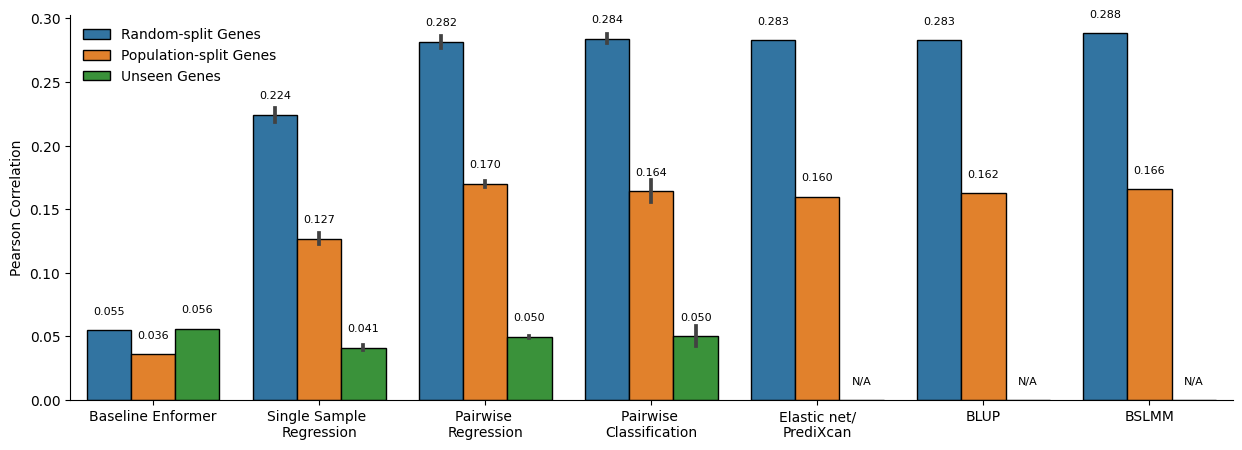

In [8]:
fontsize = 8
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        # "Pairwise \nRegression \nwith Original Data \nJoint Training",
        # "Pairwise \nClassification \nwith Original Data \nJoint Training",
        # "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        # "Top SNP",
        # "LASSO",
        "Elastic net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="Pearson Correlation", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_1a_comparison_of_main_methods.pdf", dpi=600, bbox_inches="tight"
)
plt.savefig(
    "figures/fig_1a_comparison_of_main_methods.svg", dpi=600, bbox_inches="tight"
)
# plt.tick_params(axis="x", labelrotation=45)

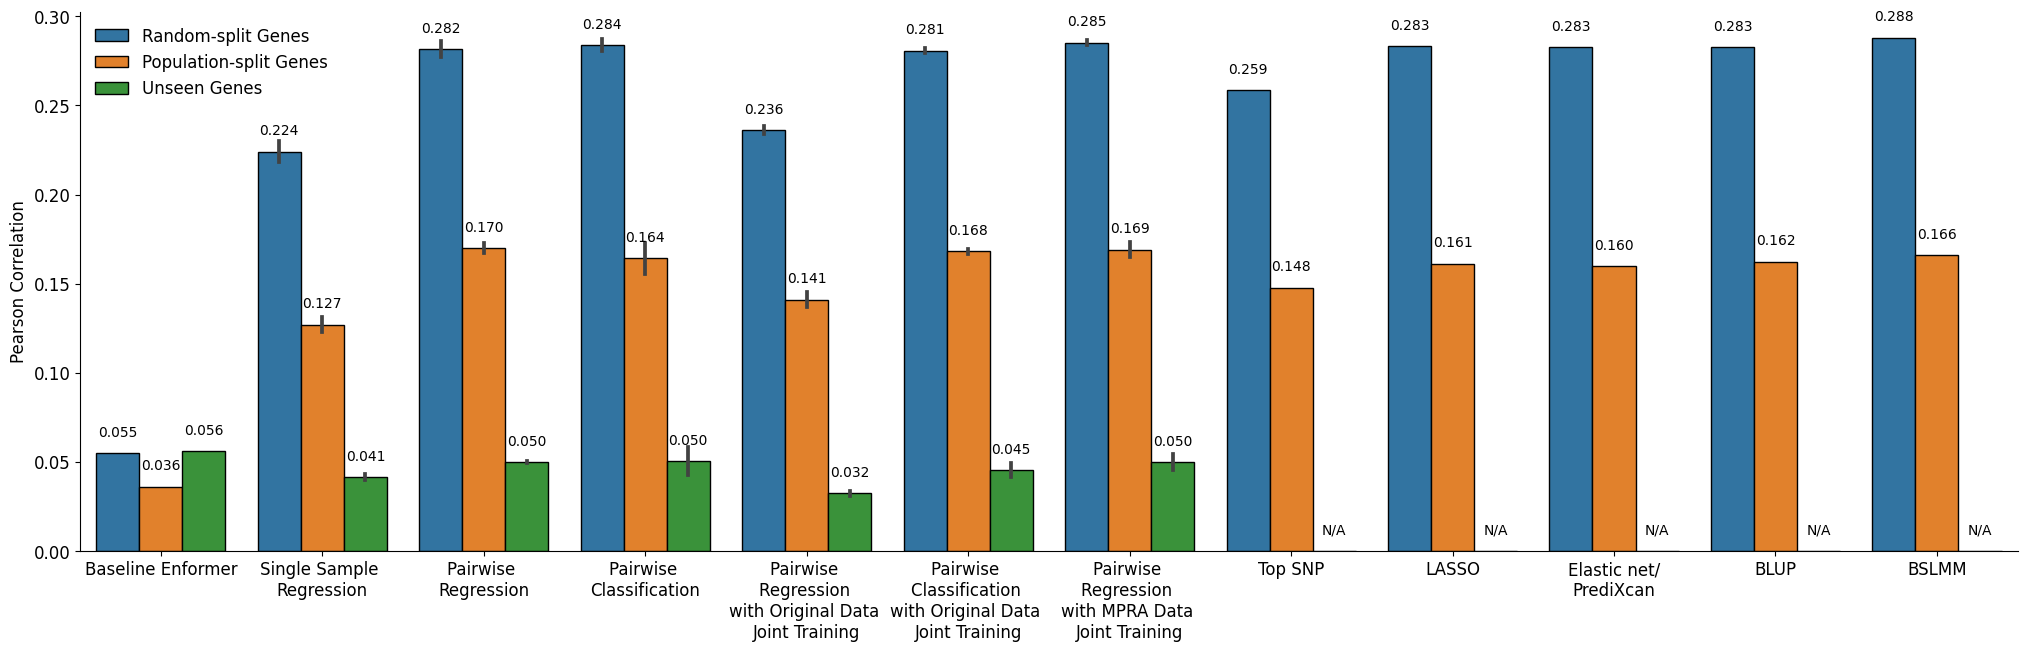

In [9]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(25, 7))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        "Pairwise \nRegression \nwith Original Data \nJoint Training",
        "Pairwise \nClassification \nwith Original Data \nJoint Training",
        "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        "Top SNP",
        "LASSO",
        "Elastic net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="Pearson Correlation", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_S3_comparison_of_all_methods.pdf", dpi=600, bbox_inches="tight"
)
plt.savefig(
    "figures/fig_S3_comparison_of_all_methods.svg", dpi=600, bbox_inches="tight"
)
# plt.tick_params(axis="x", labelrotation=45)

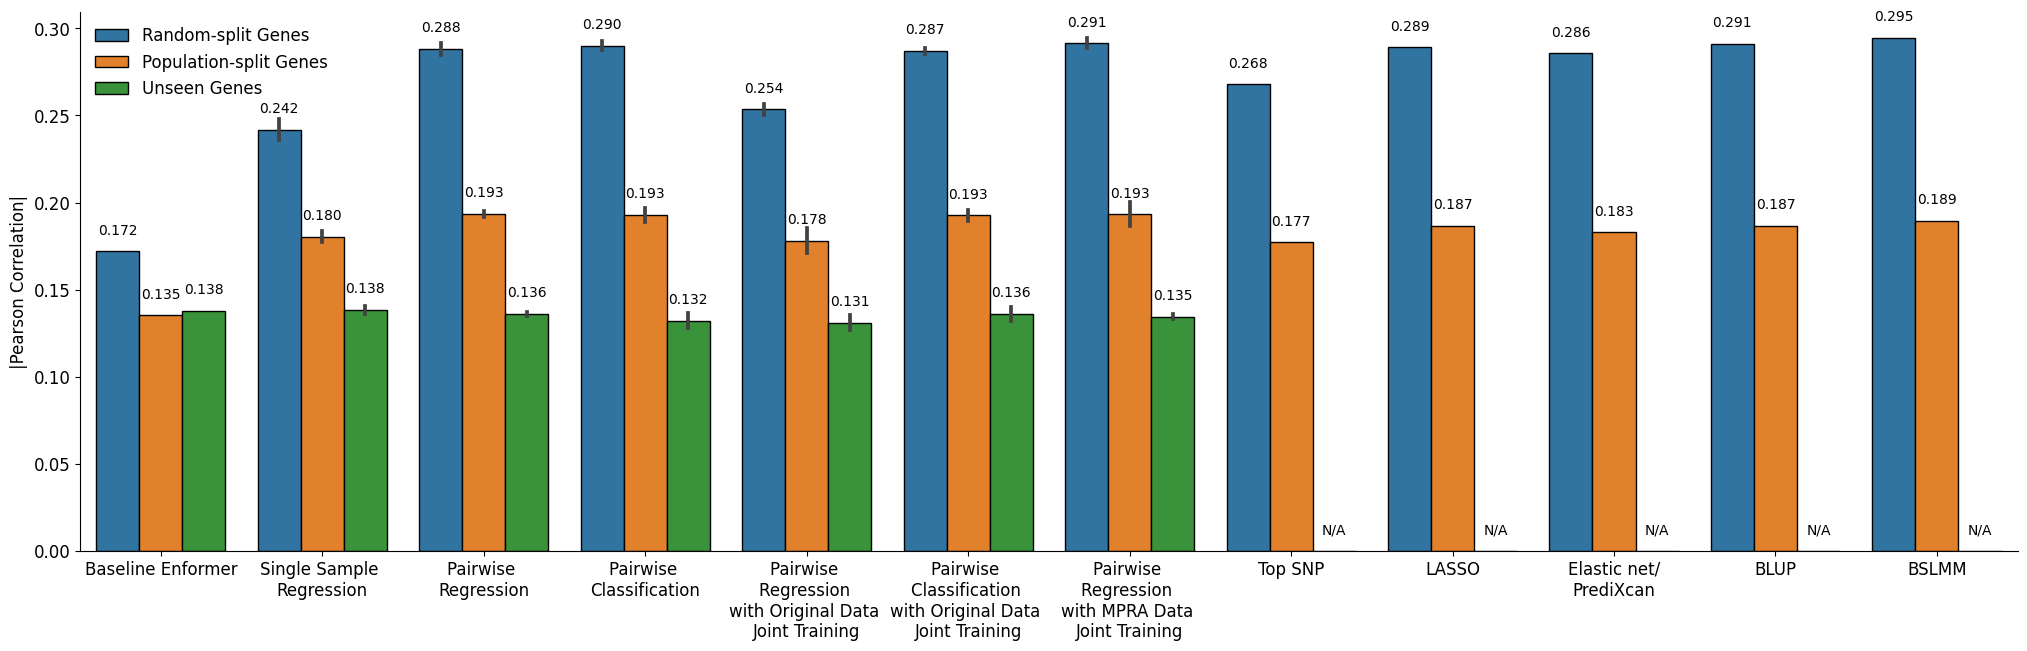

In [10]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(25, 7))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="|Pearson Correlation|",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        "Pairwise \nRegression \nwith Original Data \nJoint Training",
        "Pairwise \nClassification \nwith Original Data \nJoint Training",
        "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        "Top SNP",
        "LASSO",
        "Elastic net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="|Pearson Correlation|", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(loc="upper left", frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_S4_comparison_of_all_methods_abs_perf.pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.savefig(
    "figures/fig_S4_comparison_of_all_methods_abs_perf.svg",
    dpi=600,
    bbox_inches="tight",
)
# plt.tick_params(axis="x", labelrotation=45)

# Generate figure showing how performance scales with number of samples - fig 3a

In [11]:
plot_df = {}
plot_df["Method"] = []
plot_df["Subsample Ratio"] = []
plot_df["% of Samples Used for Training"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
plot_df["|Pearson Correlation|"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]

    if row["Subsample Ratio"] == -1 or "_af_" in row["Model"]:
        continue

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])


for i in range(fusion_scaling_df.shape[0]):
    row = fusion_scaling_df.iloc[i]

    if row["Subsample Ratio"] == -1 or "_af_" in row["Model"]:
        continue

    plot_df["Method"].append("BLUP")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("BLUP")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    # plot_df["Method"].append("BLUP")
    # plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    # plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    # plot_df["Replicate"].append(row["Replicate"])
    # plot_df["Gene Classes"].append("Unseen Genes")
    # plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    # plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

In [12]:
plot_df

,Method,Subsample Ratio,% of Samples Used for Training,Replicate,Gene Classes,Pearson Correlation,|Pearson Correlation|
0,Fine-tuned Enformer,1.0,100,42,Random-split Genes,0.277739,0.286450
1,Fine-tuned Enformer,1.0,100,42,Population-split Genes,0.167516,0.191992
2,Fine-tuned Enformer,1.0,100,42,Unseen Genes,0.050255,0.134924
3,Fine-tuned Enformer,0.2,20,42,Random-split Genes,0.219492,0.240743
4,Fine-tuned Enformer,0.2,20,42,Population-split Genes,0.129576,0.176059
...,...,...,...,...,...,...,...
70,BLUP,100.0,100,2,Population-split Genes,0.162383,0.186806
71,BLUP,100.0,100,1,Random-split Genes,0.282717,0.291098
72,BLUP,100.0,100,1,Population-split Genes,0.162383,0.186806
73,BLUP,100.0,100,3,Random-split Genes,0.282717,0.291098


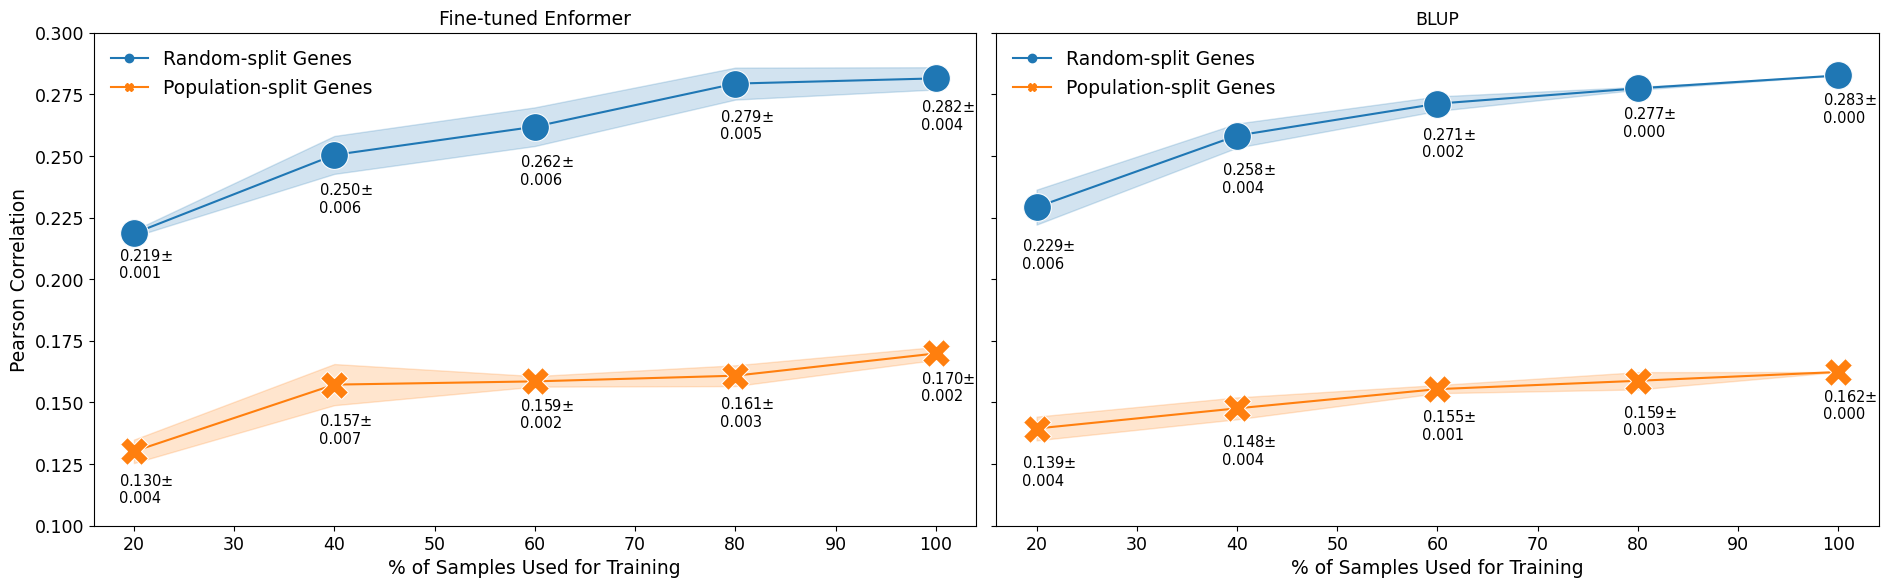

In [13]:
fontsize = 10.5
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharey=True, tight_layout=True)

sns.lineplot(
    data=plot_df[
        (plot_df["Method"] == "Fine-tuned Enformer")
        & (plot_df["Gene Classes"] != "Unseen Genes")
    ].reset_index(drop=True),
    x="% of Samples Used for Training",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    markers=True,
    dashes=False,
    markersize=20,
    #              err_style="bars",
    hue_order=["Random-split Genes", "Population-split Genes"],  # , "Unseen Genes"],
    ax=ax[0],
)

# label points on the plot
for x in set(plot_df["% of Samples Used for Training"]):
    for hue in set(plot_df["Gene Classes"]):
        corrs = plot_df[
            (plot_df["Method"] == "Fine-tuned Enformer")
            & (plot_df["% of Samples Used for Training"] == x)
            & (plot_df["Gene Classes"] == hue)
        ]["Pearson Correlation"]
        disp = f"{np.mean(corrs):.3f}" + r"$\pm$" + f"\n{np.std(corrs):.3f}"

        y_add = 0.017
        if hue == "Unseen Genes":
            y_add = 0.017
            continue
        ax[0].text(
            x=x - 1.5,  # x-coordinate position of data label
            y=np.mean(corrs)
            - np.std(corrs)
            - y_add,  # y-coordinate position of data label, adjusted to be 150 below the data point
            s=disp,  # data label, formatted to ignore decimals
            fontsize=fontsize,
            color="black",
        )  # set colour of line
ax[0].set_title("Fine-tuned Enformer", fontsize=fontsize + 3)
ax[0].legend(frameon=False, prop={"size": fontsize + 3})
ax[0].yaxis.label.set_size(fontsize + 3)
ax[0].xaxis.label.set_size(fontsize + 3)
ax[0].set_ylim(0.1, 0.3)

sns.lineplot(
    data=plot_df[plot_df["Method"] == "BLUP"].reset_index(drop=True),
    x="% of Samples Used for Training",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    markers=True,
    dashes=False,
    markersize=20,
    #              err_style="bars",
    hue_order=["Random-split Genes", "Population-split Genes"],
    ax=ax[1],
)

# label points on the plot
for x in set(plot_df["% of Samples Used for Training"]):
    for hue in set(plot_df["Gene Classes"]):
        if hue == "Unseen Genes":
            continue
        corrs = plot_df[
            (plot_df["Method"] == "BLUP")
            & (plot_df["% of Samples Used for Training"] == x)
            & (plot_df["Gene Classes"] == hue)
        ]["Pearson Correlation"]
        disp = f"{np.mean(corrs):.3f}" + r"$\pm$" + f"\n{np.std(corrs):.3f}"

        ax[1].text(
            x=x - 1.5,  # x-coordinate position of data label
            y=np.mean(corrs)
            - np.std(corrs)
            - 0.019,  # y-coordinate position of data label, adjusted to be 150 below the data point
            s=disp,  # data label, formatted to ignore decimals
            fontsize=fontsize,
            color="black",
        )  # set colour of line
ax[1].set_title("BLUP", fontsize=fontsize + 2)
ax[1].legend(frameon=False, prop={"size": fontsize + 3})
ax[1].yaxis.label.set_size(fontsize + 3)
ax[1].xaxis.label.set_size(fontsize + 3)
ax[1].set_ylim(0.1, 0.3)

plt.savefig("figures/fig_3a_perf_vs_num_samples.pdf", dpi=600, bbox_inches="tight")
plt.savefig("figures/fig_3a_perf_vs_num_samples.svg", dpi=600, bbox_inches="tight")
# plt.tick_params(axis="x", labelrotation=45)

# Generate figure showing how performance scales with min AF of variants - fig 3b

In [14]:
plot_df = {}
plot_df["Min AF"] = []
plot_df["% Mininimum AF in Training Set"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
# plot_df["|Pearson Correlation|"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]

    if row["Min AF"] == -1:
        continue

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Mininimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    #     plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Mininimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    #     plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Mininimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
#     plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

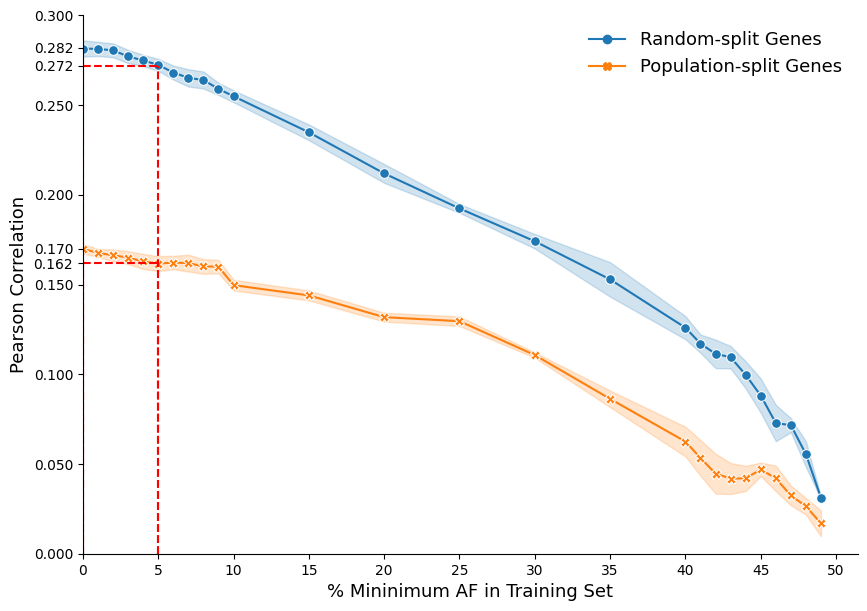

In [15]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize + 3})
matplotlib.rc("xtick", labelsize=fontsize)
matplotlib.rc("ytick", labelsize=fontsize)
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    data=plot_df[plot_df["Gene Classes"] != "Unseen Genes"],
    x="% Mininimum AF in Training Set",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    markers=True,
    dashes=False,
    markersize=7,
    hue_order=["Random-split Genes", "Population-split Genes"],
)

af0_pearson_random = (
    plot_df[
        (plot_df["% Mininimum AF in Training Set"] == 0)
        & (plot_df["Gene Classes"] == "Random-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af0_pearson_population = (
    plot_df[
        (plot_df["% Mininimum AF in Training Set"] == 0)
        & (plot_df["Gene Classes"] == "Population-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af5_pearson_random = (
    plot_df[
        (plot_df["% Mininimum AF in Training Set"] == 5)
        & (plot_df["Gene Classes"] == "Random-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af5_pearson_population = (
    plot_df[
        (plot_df["% Mininimum AF in Training Set"] == 5)
        & (plot_df["Gene Classes"] == "Population-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)

plt.vlines(
    [0, 0],
    0,
    [af0_pearson_random, af0_pearson_population],
    colors="r",
    linestyle="dashed",
)
plt.hlines(
    [af0_pearson_random, af0_pearson_population],
    0,
    [0, 0],
    colors="r",
    linestyle="dashed",
)

plt.vlines(
    [5, 5],
    0,
    [af5_pearson_random, af5_pearson_population],
    colors="r",
    linestyle="dashed",
)
plt.hlines(
    [af5_pearson_random, af5_pearson_population],
    0,
    [5, 5],
    colors="r",
    linestyle="dashed",
)

xticks = np.arange(0, max(all_afs) * 100 + 5, 5)
yticks = np.arange(0, max(plot_df["Pearson Correlation"]) + 0.025, 0.05).round(
    3
).tolist() + [
    af0_pearson_random,
    af0_pearson_population,
    af5_pearson_random,
    af5_pearson_population,
]
plt.xticks(xticks)
plt.yticks(yticks)

plt.xlim(0, None)
plt.ylim(0, None)
plt.legend(frameon=False, prop={"size": fontsize + 3})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.savefig("figures/fig_3b_perf_vs_min_AF.pdf", dpi=600, bbox_inches="tight")
plt.savefig("figures/fig_3b_perf_vs_min_AF.svg", dpi=600, bbox_inches="tight")
# plt.tick_params(axis="x", labelrotation=45)